### Librerias y Funciones

In [0]:
spark.conf.set("spark.databricks.io.cache.enabled", True)
spark.conf.set('spark.sql.shuffle.partitions', 'auto')

In [0]:
%run ../../../../../04_utils/commons_functions_de

### Librerías

### Funciones Ingenieria de datos

### Funciones de ingesta en RDS

### Funciones de control de flujo de ingesta

In [0]:
%run ../../../../../04_utils/commons_functions_ds

In [0]:
%run ../../../../../spigot/initial/global_parameter_py

In [0]:
from IPython.display import display

# mute warnings
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pyspark.sql import Window
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import plotly.express as px

sns.set_theme(style="ticks")

from datetime import datetime
from dateutil.relativedelta import relativedelta

pd.set_option('display.float_format', lambda x: '%.5f' % x)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import regexp_extract

from datetime import datetime, date

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import numpy as np

#### Carga de Fuente

In [0]:
int_pedidos_clientes = (spark.read.parquet("/Volumes/dbw_prod_aavanzada/db_tmp/files/pburbano/data/")
                                  .withColumn("fecha_pedido_dt", F.to_date(F.col("fecha_pedido_dt")))
                        )

#### MDT

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# === 0. Base ===
df = int_pedidos_clientes

# === 1. Transformaciones iniciales ===
# Convertir madurez_digital_cd a ordinal numérica
df = df.withColumn(
    "madurez_digital_val",
    F.when(F.col("madurez_digital_cd") == "BAJA", 1)
     .when(F.col("madurez_digital_cd") == "MEDIA", 2)
     .when(F.col("madurez_digital_cd") == "ALTA", 3)
     .otherwise(None)
)

# Convertir estrellas_txt a numérica
df = df.withColumn("estrellas_val", F.col("estrellas_txt").cast("int"))

# Convertir frecuencia_visitas_cd a cantidad de letras (número de días)
df = df.withColumn("frecuencia_visitas_val", F.length(F.col("frecuencia_visitas_cd")))

# === 2. Definición de ventanas ===
w = Window.partitionBy("cliente_id").orderBy(F.asc("fecha_pedido_dt"))
w_prev_all = w.rowsBetween(Window.unboundedPreceding, -1)
w_recent = w.rowsBetween(-3, -1)

# === 3. Crear canal siguiente y target multiclase ===
df = df.withColumn("canal_siguiente", F.lead("canal_pedido_cd").over(w))
df = df.filter(F.col("canal_siguiente").isNotNull())

# Target multiclase:
# 0 = NO_DIGITAL → NO_DIGITAL
# 1 = NO_DIGITAL → DIGITAL (adopta)
# 2 = DIGITAL → DIGITAL (mantiene)
# 3 = DIGITAL → NO_DIGITAL (abandona)

df = df.withColumn(
    "target",
    F.when((F.col("canal_pedido_cd") != "DIGITAL") & (F.col("canal_siguiente") != "DIGITAL"), 0)
     .when((F.col("canal_pedido_cd") != "DIGITAL") & (F.col("canal_siguiente") == "DIGITAL"), 1)
     .when((F.col("canal_pedido_cd") == "DIGITAL") & (F.col("canal_siguiente") == "DIGITAL"), 2)
     .when((F.col("canal_pedido_cd") == "DIGITAL") & (F.col("canal_siguiente") != "DIGITAL"), 3)
)

# === 4. Variables de canal binarias (DIGITAL vs NO DIGITAL) ===
df = (
    df.withColumn("canal_previo", F.lag("canal_pedido_cd").over(w))
      .withColumn("canal_actual", F.col("canal_pedido_cd"))
      .withColumn("canal_actual_digital", F.when(F.col("canal_actual") == "DIGITAL", 1).otherwise(0))
      .withColumn("canal_previo_digital", F.when(F.col("canal_previo") == "DIGITAL", 1).otherwise(0))
)

# === 5. Variables históricas ===
df = (
    df.withColumn("dias_desde_pedido_anterior", F.datediff("fecha_pedido_dt", F.lag("fecha_pedido_dt").over(w)))
      .withColumn("n_pedidos_previos", F.row_number().over(w) - 1)
      # Facturación
      .withColumn("facturacion_prom_anterior", F.avg("facturacion_usd_val").over(w_prev_all))
      .withColumn("facturacion_total_prev", F.sum("facturacion_usd_val").over(w_prev_all))
      .withColumn("desviacion_facturacion", F.stddev("facturacion_usd_val").over(w_prev_all))
      # Canal digital
      .withColumn("uso_digital_prev", F.sum(F.when(F.col("canal_pedido_cd") == "DIGITAL", 1).otherwise(0)).over(w_prev_all))
      .withColumn("uso_no_digital_prev", F.col("n_pedidos_previos") - F.col("uso_digital_prev"))
      .withColumn("prop_digital_prev", 
                  F.when(F.col("n_pedidos_previos") > 0,
                         F.col("uso_digital_prev") / F.col("n_pedidos_previos")).otherwise(0))
      .withColumn("prop_no_digital_prev", 
                  F.when(F.col("n_pedidos_previos") > 0,
                         F.col("uso_no_digital_prev") / F.col("n_pedidos_previos")).otherwise(0))
      # Frecuencia
      .withColumn("dias_media_prev", 
                  F.avg(F.datediff("fecha_pedido_dt", F.lag("fecha_pedido_dt").over(w))).over(w_prev_all))
      .withColumn("dias_media_std", 
                  F.stddev(F.datediff("fecha_pedido_dt", F.lag("fecha_pedido_dt").over(w))).over(w_prev_all))
)

# === 6. Variables recientes (últimos 3 pedidos) ===
df = (
    df.withColumn("facturacion_prom_reciente", F.avg("facturacion_usd_val").over(w_recent))
      .withColumn("uso_digital_reciente", F.avg(F.when(F.col("canal_pedido_cd") == "DIGITAL", 1).otherwise(0)).over(w_recent))
      .withColumn("uso_no_digital_reciente", F.avg(F.when(F.col("canal_pedido_cd") != "DIGITAL", 1).otherwise(0)).over(w_recent))
)

# === 7. Variables de materiales y cajas ===
df = (
    df
      .withColumn("materiales_prom_prev", F.avg("materiales_distintos_val").over(w_prev_all))
      .withColumn("materiales_total_prev", F.sum("materiales_distintos_val").over(w_prev_all))
      .withColumn("cajas_fisicas_prom_prev", F.avg("cajas_fisicas").over(w_prev_all))
      .withColumn("cajas_fisicas_total_prev", F.sum("cajas_fisicas").over(w_prev_all))
      .withColumn("materiales_reciente", F.avg("materiales_distintos_val").over(w_recent))
      .withColumn("cajas_fisicas_reciente", F.avg("cajas_fisicas").over(w_recent))
      .withColumn("cajas_por_material", 
                  F.when(F.col("materiales_distintos_val") > 0, 
                         F.col("cajas_fisicas") / F.col("materiales_distintos_val"))
                   .otherwise(0))
      .withColumn("cajas_por_material_prev", 
                  F.avg(F.when(F.col("materiales_distintos_val") > 0, 
                               F.col("cajas_fisicas") / F.col("materiales_distintos_val"))
                        .otherwise(0)).over(w_prev_all))
)

# === 8. Variables temporales ===
df = (
    df.withColumn("mes", F.month("fecha_pedido_dt"))
      .withColumn("dia_semana", F.dayofweek("fecha_pedido_dt"))
      .withColumn("es_fin_de_semana", F.when(F.col("dia_semana").isin(1, 7), 1).otherwise(0))
      .withColumn("trimestre", F.quarter("fecha_pedido_dt"))
)

# === 9. Antigüedad ===
df = df.withColumn(
    "antiguedad_dias",
    F.datediff("fecha_pedido_dt", F.min("fecha_pedido_dt").over(Window.partitionBy("cliente_id")))
)

# === 10. Selección final de variables ===
mdt = (
    df.filter(F.col("n_pedidos_previos") > 0)
      .filter(F.col("target").isNotNull())
      .select(
        # Identificadores
        "cliente_id", "pais_cd", "region_comercial_txt", "agencia_id", "ruta_id",
        "tipo_cliente_cd", "madurez_digital_cd", "estrellas_txt", "frecuencia_visitas_cd",
        # Target multiclase
        "target",
        # Canal binario
        "canal_actual_digital", "canal_previo_digital",
        # Comportamiento histórico
        "facturacion_usd_val", "dias_desde_pedido_anterior", "n_pedidos_previos",
        "facturacion_prom_anterior", "facturacion_total_prev", "desviacion_facturacion",
        "uso_digital_prev", "uso_no_digital_prev", "prop_digital_prev", "prop_no_digital_prev",
        "facturacion_prom_reciente", "uso_digital_reciente", "uso_no_digital_reciente",
        "dias_media_prev", "dias_media_std",
        # Materiales y cajas
        "materiales_distintos_val", "materiales_prom_prev", "materiales_total_prev", "materiales_reciente",
        "cajas_fisicas", "cajas_fisicas_prom_prev", "cajas_fisicas_total_prev", "cajas_fisicas_reciente",
        "cajas_por_material", "cajas_por_material_prev",
        # Temporalidad
        "mes", "dia_semana", "es_fin_de_semana", "trimestre",
        "antiguedad_dias", "fecha_pedido_dt",
        # Transformaciones
        "madurez_digital_val", "estrellas_val", "frecuencia_visitas_val"
      )
)

# === 11. Etiquetar periodo y limpiar ===
fecha_corte = "2024-03-01"
mdt = mdt.withColumn("periodo", F.when(F.col("fecha_pedido_dt") < fecha_corte, "TRAIN").otherwise("TEST"))
mdt = mdt.fillna(0)

# === 12. Proporciones de adopción digital (basadas solo en TRAIN, sin leakage) ===
prop_agencia = (
    mdt.filter("periodo == 'TRAIN'")
       .groupBy("agencia_id")
       .agg(F.avg(F.when(F.col("target").isin(2, 3), 1).otherwise(0)).alias("prop_digital_agencia"))
)
prop_ruta = (
    mdt.filter("periodo == 'TRAIN'")
       .groupBy("ruta_id")
       .agg(F.avg(F.when(F.col("target").isin(2, 3), 1).otherwise(0)).alias("prop_digital_ruta"))
)

# === 13. Join sin leakage ===
mdt = mdt.join(prop_agencia, on="agencia_id", how="left")
mdt = mdt.join(prop_ruta, on="ruta_id", how="left")


#### Modelamiento

In [0]:
mdt_pd = mdt.toPandas()

#### Division Train Test

In [0]:
mdt_pd["periodo"].value_counts(normalize=True)

periodo
TRAIN   0.75946
TEST    0.24054
Name: proportion, dtype: float64

In [0]:
mdt_pd.groupby("periodo")["target"].value_counts(normalize=True)

periodo  target
TEST     0        0.29035
         2        0.25022
         3        0.22996
         1        0.22947
TRAIN    0        0.29169
         2        0.25101
         1        0.22888
         3        0.22842
Name: proportion, dtype: float64

In [0]:
mdt_pd.groupby("periodo")["madurez_digital_val"].value_counts(normalize=True)

periodo  madurez_digital_val
TEST     1                     0.50143
         2                     0.35015
         3                     0.14842
TRAIN    1                     0.50077
         2                     0.35028
         3                     0.14895
Name: proportion, dtype: float64

In [0]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

# Creación de conjuntos de entrenamiento y prueba
cols_exclude = ["cliente_id", "target", "fecha_pedido_dt", "periodo"]

df_train = mdt_pd[mdt_pd["periodo"] == "TRAIN"]
df_test = mdt_pd[mdt_pd["periodo"] == "TEST"]

X_train = df_train.copy().drop(cols_exclude, axis=1)
X_test = df_test.copy().drop(cols_exclude, axis=1)

y_train = df_train.copy()["target"]
y_test = df_test.copy()["target"]

#Tratamiento adicional de categóricas
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# Modelo multiclass con parámetros regularizados 
n_classes = y_train.nunique()

model = LGBMClassifier(
    objective="multiclass",
    num_class=n_classes,
    learning_rate=0.01,
    n_estimators=1200,
    num_leaves=31,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=3.0,
    reg_lambda=3.0,
    min_child_samples=150,
    class_weight="balanced",
    random_state=2022
)

# === Callbacks para early stopping y logging ===
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.log_evaluation(period=0)
]

# === Entrenamiento del modelo ===
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="multi_logloss",
    callbacks=callbacks,
    categorical_feature=categorical_cols
)

# === Predicción y evaluación ===
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("Entrenamiento multiclase completado. Clases detectadas:", model.classes_)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6534
[LightGBM] [Info] Number of data points in the train set: 721779, number of used features: 45
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start t

##### Metricas Train

In [0]:
# === Predicciones ===
y_pred = model.predict(X_train)
y_pred_proba = model.predict_proba(X_train)
classes = model.classes_

# === Matriz de Confusión ===
print("Matriz de Confusión:")
print(confusion_matrix(y_train, y_pred))

# === Clasificación general ===
print("\nClassification Report:")
print(classification_report(y_train, y_pred))

# === Balanced Accuracy ===
balanced_acc = balanced_accuracy_score(y_train, y_pred)
print("\nBalanced Accuracy:", round(balanced_acc, 4))

# === ROC AUC Multiclase ===
# Binarizar labels para calcular AUC multiclase
y_train_bin = label_binarize(y_train, classes=classes)

auc_macro = roc_auc_score(y_train_bin, y_pred_proba, average="macro", multi_class="ovr")
auc_weighted = roc_auc_score(y_train_bin, y_pred_proba, average="weighted", multi_class="ovr")

print("ROC AUC Macro:", round(auc_macro, 4))
print("ROC AUC Weighted:", round(auc_weighted, 4))

# === Gini Coefficient ===
# Gini = 2 * AUC - 1
gini_macro = 2 * auc_macro - 1
gini_weighted = 2 * auc_weighted - 1

print("Gini Macro:", round(gini_macro, 4))
print("Gini Weighted:", round(gini_weighted, 4))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Matriz de Confusión:
[[151662  58877      0      0]
 [ 79678  85520      0      0]
 [     0      0 122402  58769]
 [     0      0  61559 103312]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69    210539
           1       0.59      0.52      0.55    165198
           2       0.67      0.68      0.67    181171
           3       0.64      0.63      0.63    164871

    accuracy                           0.64    721779
   macro avg       0.64      0.64      0.64    721779
weighted avg       0.64      0.64      0.64    721779


Balanced Accuracy: 0.6351
ROC AUC Macro: 0.8974
ROC AUC Weighted: 0.8976
Gini Macro: 0.7948
Gini Weighted: 0.7952


##### Metricas Test

In [0]:
# === Predicciones ===
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
classes = model.classes_

# === Matriz de Confusión ===
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# === Clasificación general ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# === Balanced Accuracy ===
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("\nBalanced Accuracy:", round(balanced_acc, 4))

# === ROC AUC Multiclase ===
# Binarizar labels para calcular AUC multiclase
y_test_bin = label_binarize(y_test, classes=classes)

auc_macro = roc_auc_score(y_test_bin, y_pred_proba, average="macro", multi_class="ovr")
auc_weighted = roc_auc_score(y_test_bin, y_pred_proba, average="weighted", multi_class="ovr")

print("ROC AUC Macro:", round(auc_macro, 4))
print("ROC AUC Weighted:", round(auc_weighted, 4))

# === Gini Coefficient ===
# Gini = 2 * AUC - 1
gini_macro = 2 * auc_macro - 1
gini_weighted = 2 * auc_weighted - 1

print("Gini Macro:", round(gini_macro, 4))
print("Gini Weighted:", round(gini_weighted, 4))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Matriz de Confusión:
[[47313 19063     0     0]
 [25895 26563     0     0]
 [    0     0 36580 20621]
 [    0     0 20813 31758]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68     66376
           1       0.58      0.51      0.54     52458
           2       0.64      0.64      0.64     57201
           3       0.61      0.60      0.61     52571

    accuracy                           0.62    228606
   macro avg       0.62      0.62      0.62    228606
weighted avg       0.62      0.62      0.62    228606


Balanced Accuracy: 0.6157
ROC AUC Macro: 0.8805
ROC AUC Weighted: 0.8806
Gini Macro: 0.761
Gini Weighted: 0.7613


##### Analisis de Caracteristicas

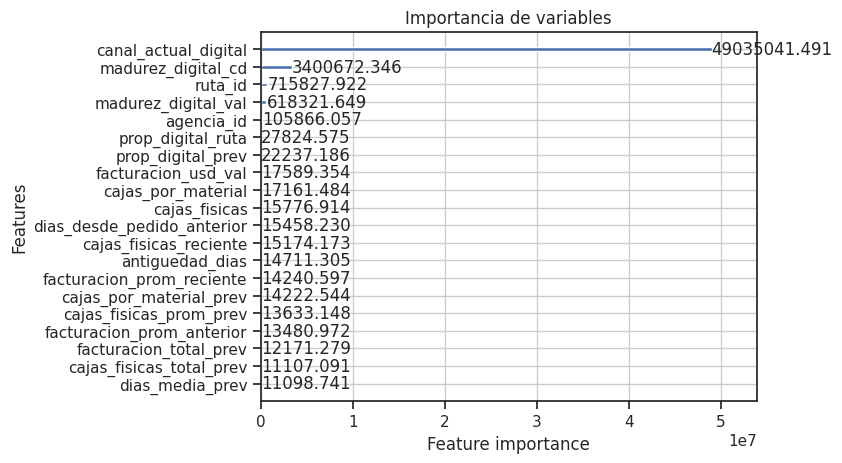

In [0]:
# importancia de caracteristicas
lgb.plot_importance(model, max_num_features=20, importance_type='gain') 
plt.title("Importancia de variables")
plt.show()